Testing: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]
c:\Users\Emircan\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Emircan\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Emircan\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

F1-Score: 0.1949
Precision: 0.2928
Recall: 0.2077

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00         4
                                 Apple___Black_rot       0.00      0.00      0.00         5
                          Apple___Cedar_apple_rust       0.00      0.00      0.00         4
                                   Apple___healthy       1.00      0.50      0.67         4
                               Blueberry___healthy       0.25      1.00      0.40         1
          Cherry_(including_sour)___Powdery_mildew       1.00      0.50      0.67         4
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00         4
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.25      1.00      0.40         4
                       Corn_(maize)___Common_rust_       0.08      0.25      0.12         4
     

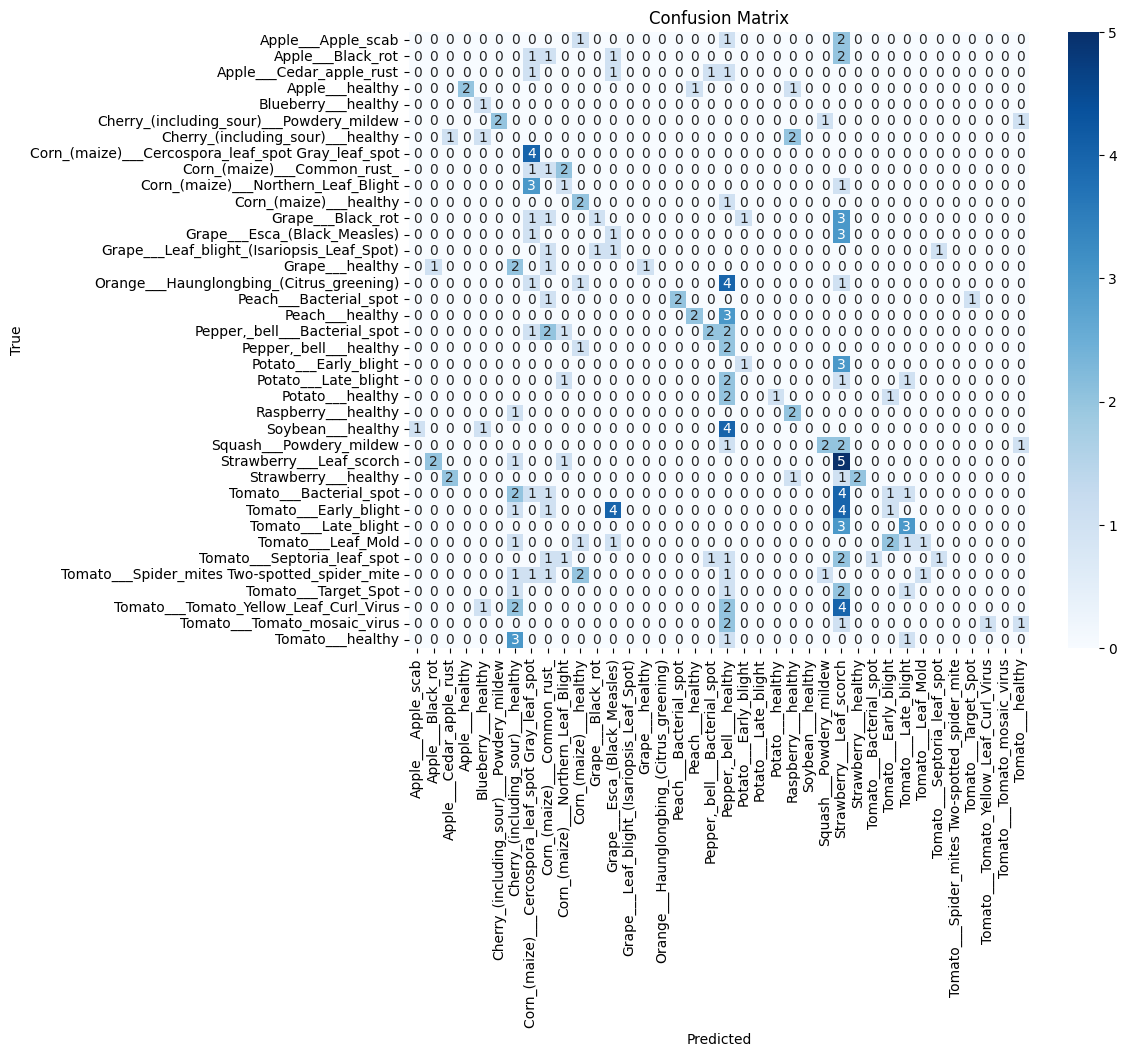

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

train_path = r"D:\PlantMaster\Dataset\DuzenlenmisPG-tts\train"
test_path = r"D:\PlantMaster\Dataset\test3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model_path = r"D:\PlantMaster\PlantMaster_Model\modeller\resnet50\best_plant_disease_model_resnet.pth"
model.load_state_dict(torch.load(model_path))

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_resnet.png')
plt.show()